In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Load historical data from Yahoo Finance
df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1262304000&period2=1620633600&interval=1d&events=history&includeAdjustedClose=true')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496294,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507526,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392176,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434673,447610800


In [3]:
# Select the closing price as predictor variable
data = df.filter(['Close']).values

# Split data into training and testing sets
train_data_len = int(np.ceil(0.8 * len(data)))
train_data = data[0:train_data_len,:]
test_data = data[train_data_len:,:]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [4]:
# Create training data for LSTM model
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
     

In [5]:
# Reshape input data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
     


In [7]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train LSTM model
model.fit(X_train, y_train, epochs=20, batch_size=64)

# Test LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/20
35/35 [==============================] - 8s 67ms/step - loss: 0.0403
Epoch 2/20
35/35 [==============================] - 2s 66ms/step - loss: 0.0011
Epoch 3/20
35/35 [==============================] - 2s 69ms/step - loss: 5.4262e-04
Epoch 4/20
35/35 [==============================] - 3s 77ms/step - loss: 5.1524e-04
Epoch 5/20
35/35 [==============================] - 3s 98ms/step - loss: 4.8285e-04
Epoch 6/20
35/35 [==============================] - 2s 71ms/step - loss: 4.6493e-04
Epoch 7/20
35/35 [==============================] - 2s 68ms/step - loss: 4.5537e-04
Epoch 8/20
35/35 [==============================] - 2s 71ms/step - loss: 4.4576e-04
Epoch 9/20
35/35 [==============================] - 3s 86ms/step - loss: 4.5875e-04
Epoch 10/20
35/35 [==============================] - 3s 90ms/step - loss: 4.3304e-04
Epoch 11/20
35/35 [==============================] - 2s 68ms/step - loss: 4.1056e-04
Epoch 12/20
35/35 [==============================] - 2s 66ms/step - loss: 4.5818e-

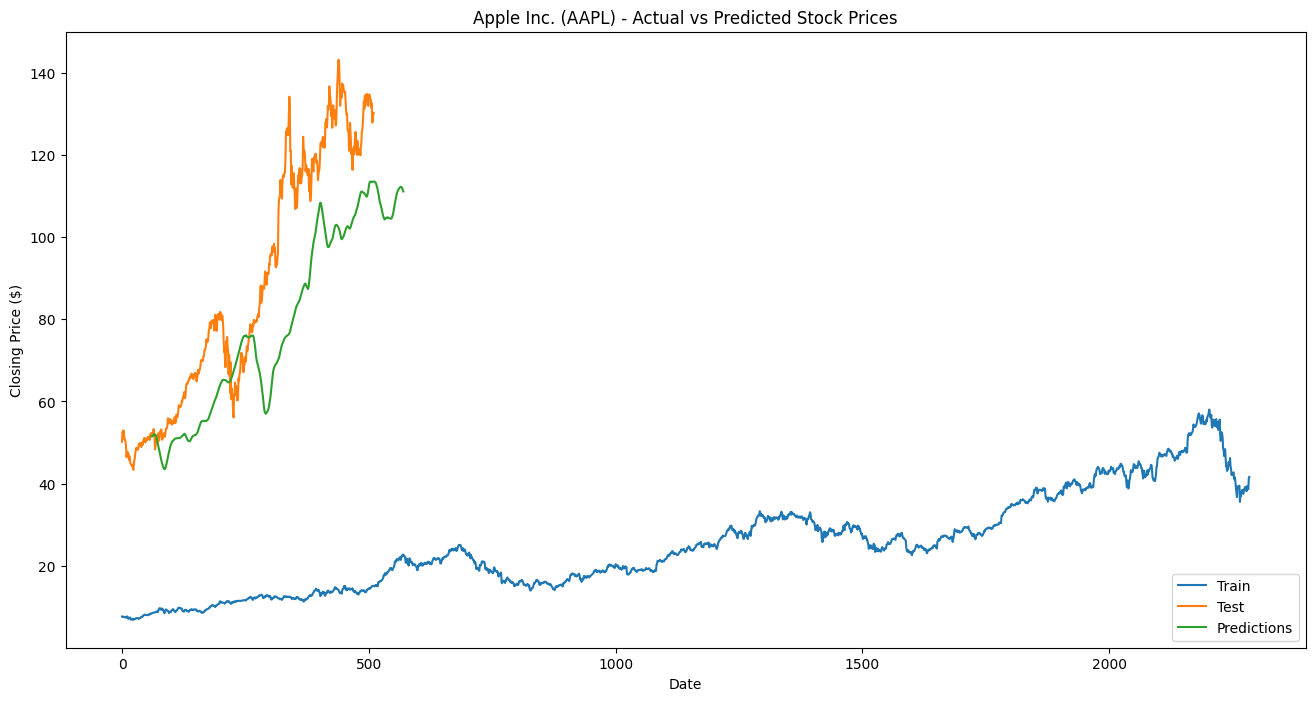

In [9]:
# Plot actual vs predicted stock prices
train = data[:train_data_len]
test = data[train_data_len+time_step:]
test_predictions = np.empty_like(test_data)
test_predictions[:, :] = np.nan
test_predictions[len(test_data)-len(predictions):, :] = predictions
plt.figure(figsize=(16,8))
plt.title('Apple Inc. (AAPL) - Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.plot(train[:, 0])
plt.plot(test[:, 0])
plt.plot(test_predictions[:, 0])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()
